In [1]:
import numpy as np
import matplotlib.pyplot as plt
from aeons.utils import *
from aeons.regress import *
from aeons.endpoint import *
from aeons.plotting import *
figsettings()

In [131]:
def get_beta_DKL(points, ndead):
    logX = points.logX().iloc[ndead]
    if logX < -points.D_KL():
        return 1
    def func(beta):
        return logX + points.set_beta(beta).D_KL()
    from scipy import optimize
    res = optimize.root_scalar(func, bracket=[0, 1])
    return res.root

def get_beta_end(points, ndead, epsilon=1e-3):
    logX = points.logX()
    logL = points.logL
    # Check if already terminated
    logw = logL + logX
    w = np.exp(logw - logw.max())
    Zdead = np.sum(w[:ndead])
    Zlive = np.sum(w[ndead:])
    if (Zdead != 0):
        if (Zlive/Zdead < epsilon):
            return 1
    # Otherwise, find beta
    def func(beta):
        logw = beta * logL + logX
        w = np.exp(logw - logw.max())
        Zdead = np.sum(w[:ndead])
        Zlive = np.sum(w[ndead:])
        if (Zdead == 0):
            return np.inf
        return Zlive/Zdead - epsilon
    from scipy import optimize
    try:
        res = optimize.root_scalar(func, bracket=[0, 1])
        return res.root
    except:
        return 0
    
def get_beta_start(points, ndead, epsilon=1e-3):
    logX = points.logX()
    logL = points.logL
    # Check if already terminated
    logw = logL + logX
    w = np.exp(logw - logw.max())
    Zdead = np.sum(w[:ndead])
    Zlive = np.sum(w[ndead:])
    if Zlive/Zdead < epsilon:
        return 1
    # Otherwise, find beta
    def func(beta):
        logw = beta * logL + logX
        w = np.exp(logw - logw.max())
        Zdead = np.sum(w[:ndead])
        Zlive = np.sum(w[ndead:])
        return Zlive/Zdead - 1/epsilon
    from scipy import optimize
    try:
        res = optimize.root_scalar(func, bracket=[0, 1])
        return res.rootd
    except:
        return 0

In [171]:
def logXf_dG_range_comb(points, ndead, Nset=25):
    logL, X_mean, nk, logZdead = data(points)
    beta_end = get_beta_end(points, ndead)
    beta_DKL = get_beta_DKL(points, ndead)
    if beta_end == 0:
        betas = np.linspace(0, beta_DKL, 10)
    else:
        betas = np.exp(np.linspace(np.log(beta_end), np.log(beta_DKL), 10))
    dG = points.d_G(nsamples=25, beta=betas)
    dG_mean, dG_std = dG.mean(), dG.std()
    ds = np.zeros(Nset)
    for i in range(Nset):
        X = generate_Xs(nk)
        ds[i] = analytic_lm_params(logL[ndead:], X[ndead:], d0=1)[1]
    d_mean, d_std = ds.mean(), ds.std()
    dcomb = (dG_mean*d_std**2 + d_mean*dG_std**2)/(d_std**2 + dG_std**2)
    dcomb_std = np.sqrt((d_std**2 * dG_std**2)/(d_std**2 + dG_std**2))
    
    logXf_set = np.zeros(Nset)
    for i in range(Nset):
        X = generate_Xs(nk)
        d = np.random.normal(dcomb, dcomb_std)
        if d < 0:
            logXf_set[i] = np.nan
            continue
        theta = params_from_d(logL[ndead:], X[ndead:], d)
        logXf_set[i] = logXf_formula(theta, logZdead, X_mean[ndead])
    logXf_set = logXf_set[~np.isnan(logXf_set)]
    logXf_set = reject_outliers(logXf_set, 3)
    return logXf_set, f"{beta_DKL:.2e}, {beta_end:.2e}"

def logXf_dG_range(points, ndead, Nset=25):
    logL, X_mean, nk, logZdead = data(points)
    beta_end = get_beta_end(points, ndead)
    beta_DKL = get_beta_DKL(points, ndead)
    if beta_end == 0:
        betas = np.linspace(0, beta_DKL, 10)
    elif (beta_end*beta_DKL == 1):
        betas = 1
    else:
        betas = np.exp(np.linspace(np.log(beta_end), np.log(beta_DKL), 10))
    dG = points.d_G(nsamples=25, beta=betas)
    dG_mean, dG_std = dG.mean(), dG.std()
    
    logXf_set = np.zeros(Nset)
    for i in range(Nset):
        X = generate_Xs(nk)
        d = np.random.normal(dG_mean, dG_std)
        while d < 0:
            d = np.random.normal(dG_mean, dG_std)
        theta = params_from_d(logL[ndead:], X[ndead:], d)
        logXf_set[i] = logXf_formula(theta, logZdead, X_mean[ndead])
    logXf_set = logXf_set[~np.isnan(logXf_set)]
    logXf_set = reject_outliers(logXf_set, 3)
    return logXf_set, f"{beta_DKL:.2e}, {beta_end:.2e}"

def logXf_short(points, ndead, Nset=25):
    logL, X_mean, nk, logZdead = data(points)
    nlive = len(logL) - ndead
    start = ndead + int(0.75*nlive)
    logLd = logL[start:]
    logXf_set = np.zeros(Nset)
    for i in range(Nset):
        X = generate_Xs(nk)
        Xd = X[start:]
        theta = analytic_lm_params(logLd, Xd, d0=1)
        logXf_set[i] = logXf_formula(theta, logZdead, X_mean[ndead])
        if theta[1] > 360:
            theta = analytic_lm_params(logLd[:-100], Xd[:-100], d0=1)
            logXf_set[i] = logXf_formula(theta, logZdead, X_mean[ndead])
    logXf_set = logXf_set[~np.isnan(logXf_set)]
    logXf_set = reject_outliers(logXf_set)
    return logXf_set, f'{len(logXf_set)} samples'

def logXf_dG_logL(points, ndead, Nset=25):
    logL, X_mean, nk, logZdead = data(points)
    beta_logL = points.beta_s.iloc[ndead]
    dG = points.d_G(nsamples=25, beta=beta_logL)
    
    logXf_set = np.zeros(Nset)
    for i in range(Nset):
        X = generate_Xs(nk)
        d = np.random.choice(dG)
        theta = params_from_d(logL[ndead:], X[ndead:], d)
        logXf_set[i] = logXf_formula(theta, logZdead, X_mean[ndead])
    logXf_set = logXf_set[~np.isnan(logXf_set)]
    return logXf_set, f"{beta_logL:.2e}, {len(logXf_set)} samples"

In [ ]:
test_chains = ['gauss_32', 'cauchy_83', 'BAO', 'planck']
ylims = [(0, 1.4), (0, 2), (0, 1.2), (0, 1.3)]
fig, axs = plt.subplots(2, 2, figsize=(8, 4))
axs = axs.flatten()
for i, chain in enumerate(test_chains):
    name, samples = get_samples(chain)
    iterations, logXfs, logXfs_std, true_endpoint = read_from_txt(f"data/dG_logL_{name}.txt")
    logXf_true = samples.logX().iloc[int(true_endpoint)]
    logXs = samples.logX().iloc[iterations]
    plot_std(-logXs, -logXfs, logXfs_std, -logXf_true, ax=axs[i], color='slateblue', ylim=ylims[i])
    axs[i].set_title(name)
fig.suptitle("$d_\\mathrm{G}$ fit with $\\beta(\\log\\mathcal{L}^* = \\langle \\log \\mathcal{L}\\rangle_\\mathcal{P})$")
fig.tight_layout()

In [4]:
def beta_s(samples):
    from scipy.interpolate import interp1d
    beta = np.logspace(-14, 14, 1000)
    logL = samples.logL_P(beta=beta)/beta
    i = np.argmin(logL < samples.logL.max())
    beta = np.concatenate([[0],beta[:i+1]])
    logL = np.concatenate([[samples.logL.min()],logL.iloc[:i+1]])
    f = interp1d(logL, beta)
    samples['beta_s'] = f(samples.logL)

In [ ]:
from anesthetic import NestedSamples
from pandas import concat

name, samples = get_samples('planck_gaussian')
beta_s(samples)
plt.plot(samples.logX(), samples.beta_s)
plt.yscale('log')
plt.xlabel('$\\log X$')
plt.ylabel(r'$\beta_*$')

i= 10000
points = NestedSamples(concat([samples[:i], samples.live_points(i)])).recompute()
beta_s(points)
plt.plot(points.logX(), points.beta_s)
plt.axvline(samples.logX()[i], color='k', linestyle='--')

In [156]:
def logXf_formula(theta, logZdead, Xi, epsilon=1e-3):
    logLmax, d, sigma = theta
    loglive = loggamma(d/2) + np.log(gammainc(d/2, Xi**(2/d)/(2*sigma**2)) )
    logdead = logZdead - logLmax - (d/2)*np.log(2) - d*np.log(sigma) + np.log(2/d)
    logend = logsumexp([loglive, logdead]) + np.log(epsilon)
    # if (gammainc(d/2, Xi**(2/d)/(2*sigma**2)) > 1 - epsilon):
    if logend > loggamma(d/2):
        return d/2 * np.log(2) + d*np.log(sigma) + loggamma(1 + d/2) + np.log(epsilon)
    xf_reg = gammaincinv(d/2, np.exp(logend - loggamma(d/2)))
    return d/2 * np.log(2*sigma**2 * xf_reg)

In [213]:
name, samples = get_samples('gauss_32')
# beta_s(samples)
model = EndModel(samples)
true_endpoint = model.true_endpoint()
true_logXf = model.true_logXf()

In [218]:
iterations

array([ 2667,  4694,  6721,  8748, 10775, 12803, 14830, 16857, 18884,
       20911, 22938, 24965, 26993, 29020, 31047, 33074, 35101, 37128,
       39155, 41183, 43210, 45237, 47264, 49291, 51318])

In [237]:
ndead = 16857
points = model.points(ndead)
logXf_dG_range(points, ndead)

(array([-104.24924363,  -93.10576151,  -96.79630767, -113.39541883,
         -99.2742925 ,  -98.17234109,  -93.37766029, -103.08457134,
        -106.92873938, -100.89952978,  -94.50130765, -100.0989394 ,
         -86.64046429, -102.06009177,  -86.56077642,  -95.01518719,
         -88.89323156, -101.7845564 ,  -85.695394  , -112.03382645]),
 '3.40e-02, 1.14e-02')

In [214]:
iterations = make_iterations(true_endpoint, 25)
logXfs, logXfs_std = model.logXfs(logXf_dG_range, iterations, Nset=25)

 Iteration 2667 of 51318, 5.39e-03, 0.00e+00

/home/zixiao/Documents/III/project/aeons/aeons/regress.py:24: RuntimeWarning: divide by zero encountered in scalar divide
  return 1/n * logsum + 1/(2*n*sigma_squared_analytic(d, X_i, logL_i)) * sum_X_2d
/tmp/ipykernel_154484/3777107321.py:3: RuntimeWarning: divide by zero encountered in scalar divide
  loglive = loggamma(d/2) + np.log(gammainc(d/2, Xi**(2/d)/(2*sigma**2)) )
/tmp/ipykernel_154484/3777107321.py:4: RuntimeWarning: divide by zero encountered in log
  logdead = logZdead - logLmax - (d/2)*np.log(2) - d*np.log(sigma) + np.log(2/d)
/tmp/ipykernel_154484/3777107321.py:4: RuntimeWarning: invalid value encountered in scalar subtract
  logdead = logZdead - logLmax - (d/2)*np.log(2) - d*np.log(sigma) + np.log(2/d)


 Iteration 6721 of 51318, 9.43e-03, 3.02e-03

/tmp/ipykernel_154484/1036989968.py:20: RuntimeWarning: overflow encountered in scalar divide
  if (Zlive/Zdead < epsilon):
/tmp/ipykernel_154484/1036989968.py:30: RuntimeWarning: overflow encountered in scalar divide
  return Zlive/Zdead - epsilon


 Iteration 51318 of 51318, 1.00e+00, 8.65e-01

In [216]:
write_to_txt(f"data/dG_range_{name}.txt", [iterations, logXfs, logXfs_std, true_endpoint])

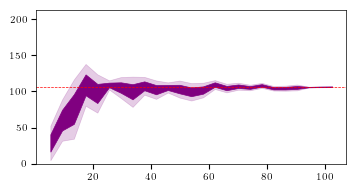

In [217]:
fig, ax = plt.subplots()
# iterations, logXfs, logXfs_std, true_endpoint = read_from_txt(f"data/dG_DKL_{name}.txt")
logXs = samples.logX().iloc[iterations]
logXf_true = samples.logX().iloc[int(true_endpoint)]
plot_std(-logXs, -logXfs, logXfs_std, -logXf_true, color='purple', ax=ax, ylim=(0, 2))

In [30]:
ndead = 9000
points = model.points(ndead)

from scipy.interpolate import interp1d
beta = np.logspace(-14, 14, 1000)
logX = -samples.D_KL(beta=beta)
beta = np.concatenate([[0],beta])
logX = np.concatenate([[0],logX])
beta_DKL_func = interp1d(logX, beta)
beta_DKL_func(samples.logX())[ndead]

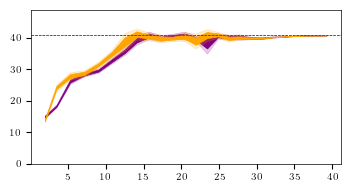

In [62]:
fig, ax = plt.subplots()
iterations, logXfs, logXfs_std, true_endpoint = read_from_txt(f"data/dG_logL_{name}.txt")
logXs = samples.logX().iloc[iterations]
logXf_true = samples.logX().iloc[int(true_endpoint)]
plot_std(-logXs, -logXfs, logXfs_std, -logXf_true, color='purple', ax=ax)

iterations, logXfs, logXfs_std, true_endpoint = read_from_txt(f"data/dG_DKL_{name}.txt")
logXs = samples.logX().iloc[iterations]
plot_std(-logXs, -logXfs, logXfs_std, -logXf_true, color='orange', ax=ax, ylim=(0, 1.2))

In [42]:
ndead = 10000
points = model.points(ndead)
logXf_dG_logL(points, ndead, Nset=25)

(array([-40.15166146, -38.99148832, -40.13699961, -39.98069818,
        -40.55096751, -40.55647852, -40.01752856, -39.54928351,
        -38.93942458, -40.83512885, -41.06141084, -40.42114829,
        -40.37811923, -39.96091784, -41.84053695, -39.24759674,
        -40.69301044, -40.69639449, -40.25745447, -40.44037344,
        -40.86321912, -39.82662807, -41.21308338, -40.45387587,
        -40.85198547]),
 '3.48e-03, 25 samples')

In [27]:
beta = np.logspace(-14, 14, 1000)
logL = samples.logL_P(beta=beta)/beta
i = np.argmin(logL < samples.logL.max())
logL = np.concatenate([[samples.logL.min()],logL.iloc[:i+1]])

In [ ]:
beta = np.logspace(-14, 14, 1000)
logL = samples.logL_P(beta=beta)/beta
i = np.argmin(logL < samples.logL.max())
beta = np.concatenate([[0],beta[:i+1]])
logL = np.concatenate([[samples.logL.min()],logL.iloc[:i+1]])
f = interp1d(logL, beta)